# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [1]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [2]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [5]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [6]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [7]:
def train_epoch(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = loss_fn(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = loss_fn(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [8]:
embedding_net = EmbeddingNet().to(device)
n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [ ]:
for epoch in range(n_epochs):
    
    # Train stage
    train_loss, acc = train_epoch(train_loader, model, loss_fn, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, loss_fn)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Epoch: 1/10. Train set: Average loss: 1.2986 Accuracy: 50.43
Epoch: 1/10. Validation set: Average loss: 0.9139 Accuracy: 68.01
Epoch: 2/10. Train set: Average loss: 0.7527 Accuracy: 76.97
Epoch: 2/10. Validation set: Average loss: 0.6901 Accuracy: 79.75
Epoch: 3/10. Train set: Average loss: 0.5921 Accuracy: 82.93
Epoch: 3/10. Validation set: Average loss: 0.6103 Accuracy: 83.15
Epoch: 4/10. Train set: Average loss: 0.4852 Accuracy: 85.82
Epoch: 4/10. Validation set: Average loss: 0.5091 Accuracy: 85.95
Epoch: 5/10. Train set: Average loss: 0.4195 Accuracy: 87.97
Epoch: 5/10. Validation set: Average loss: 0.4785 Accuracy: 86.40
Epoch: 6/10. Train set: Average loss: 0.3800 Accuracy: 89.09
Epoch: 6/10. Validation set: Average loss: 0.4708 Accuracy: 87.07
Epoch: 7/10. Train set: Average loss: 0.3396 Accuracy: 89.91
Epoch: 7/10. Validation set: Average loss: 0.4219 Accuracy: 88.51
Epoch: 8/10. Train set: Average loss: 0.3109 Accuracy: 90.70
Epoch: 8/10. Validation set: Average loss: 0.3913 

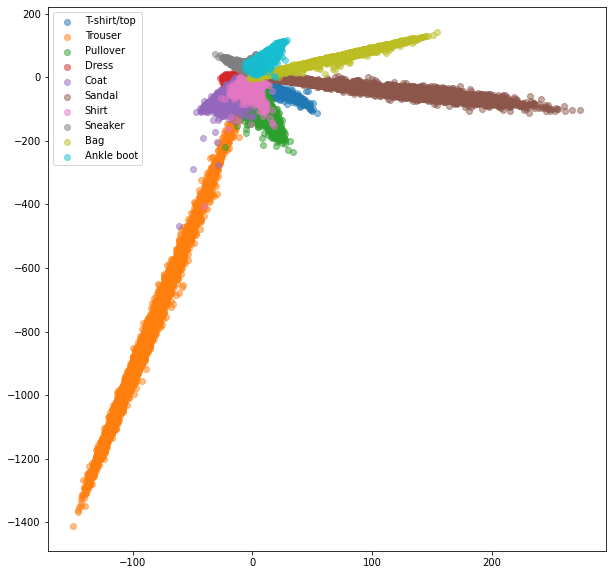

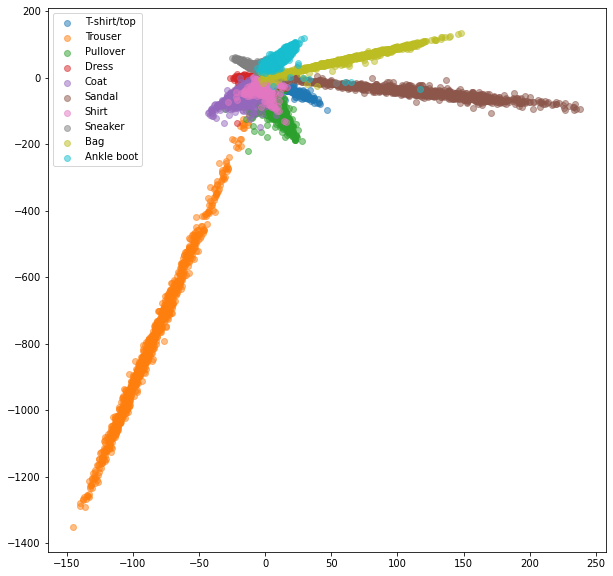

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [9]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
            
        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through thransform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target

        
    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [10]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

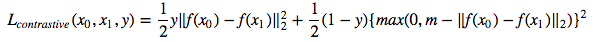

In [11]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [12]:
def train_epoch_siamese(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = loss_fn(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = loss_fn(output1, output2, target)
        val_loss += loss.item()
        
    return val_loss

In [13]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)

batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [ ]:
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, loss_fn, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, loss_fn)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Epoch: 1/10. Train set: Average loss: 0.0523
Epoch: 1/10. Validation set: Average loss: 0.0413
Epoch: 2/10. Train set: Average loss: 0.0395
Epoch: 2/10. Validation set: Average loss: 0.0377
Epoch: 3/10. Train set: Average loss: 0.0349
Epoch: 3/10. Validation set: Average loss: 0.0359
Epoch: 4/10. Train set: Average loss: 0.0322
Epoch: 4/10. Validation set: Average loss: 0.0333
Epoch: 5/10. Train set: Average loss: 0.0294
Epoch: 5/10. Validation set: Average loss: 0.0325
Epoch: 6/10. Train set: Average loss: 0.0273
Epoch: 6/10. Validation set: Average loss: 0.0311
Epoch: 7/10. Train set: Average loss: 0.0269
Epoch: 7/10. Validation set: Average loss: 0.0301
Epoch: 8/10. Train set: Average loss: 0.0250
Epoch: 8/10. Validation set: Average loss: 0.0309
Epoch: 9/10. Train set: Average loss: 0.0214
Epoch: 9/10. Validation set: Average loss: 0.0271
Epoch: 10/10. Train set: Average loss: 0.0200
Epoch: 10/10. Validation set: Average loss: 0.0267


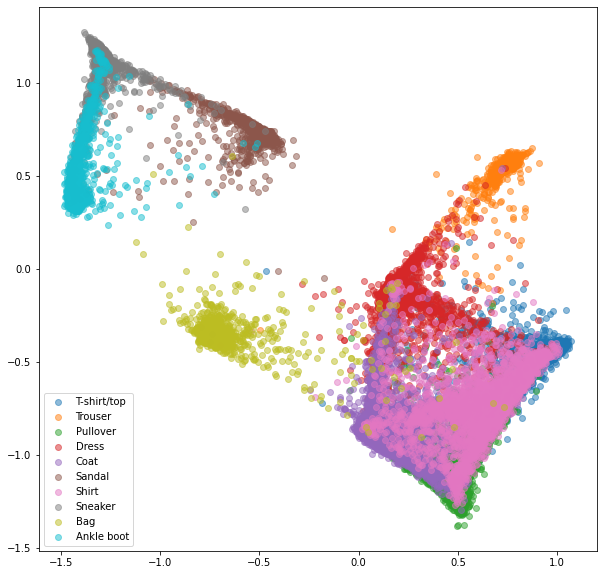

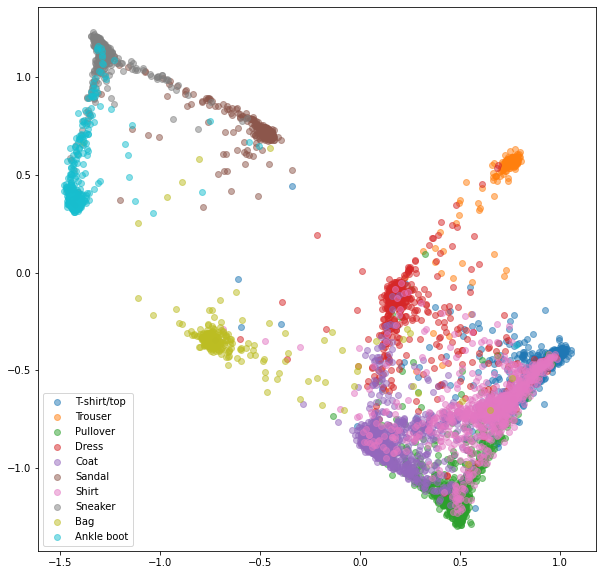

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings. 

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

In [14]:
!pip install pytorch-metric-learning faiss-gpu

     |████████████████████████████████| 112kB 8.0MB/s 
     |████████████████████████████████| 89.7MB 41kB/s 


In [15]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [16]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [17]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 1.0234092473983765, Number of mined triplets = 50054
Epoch 1 Iteration 20: Loss = 0.943767786026001, Number of mined triplets = 19382
Epoch 1 Iteration 40: Loss = 0.9796167016029358, Number of mined triplets = 30754
Epoch 1 Iteration 60: Loss = 0.9945118427276611, Number of mined triplets = 40239
Epoch 1 Iteration 80: Loss = 1.0317902565002441, Number of mined triplets = 31706
Epoch 1 Iteration 100: Loss = 0.9910039901733398, Number of mined triplets = 28001
Epoch 1 Iteration 120: Loss = 0.9565265774726868, Number of mined triplets = 31004
Epoch 1 Iteration 140: Loss = 1.0633656978607178, Number of mined triplets = 33419
Epoch 1 Iteration 160: Loss = 0.9639477133750916, Number of mined triplets = 42386
Epoch 1 Iteration 180: Loss = 0.9981653094291687, Number of mined triplets = 27898
Epoch 1 Iteration 200: Loss = 0.9970636963844299, Number of mined triplets = 36588
Epoch 1 Iteration 220: Loss = 0.9573547840118408, Number of mined triplets = 32495
Epoch 1 Ite

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Iteration 460: Loss = 0.948682963848114, Number of mined triplets = 19271


100%|██████████| 313/313 [00:01<00:00, 169.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7189
Epoch 2 Iteration 0: Loss = 1.0302835702896118, Number of mined triplets = 26103
Epoch 2 Iteration 20: Loss = 0.9904844760894775, Number of mined triplets = 31076
Epoch 2 Iteration 40: Loss = 1.0010040998458862, Number of mined triplets = 36345
Epoch 2 Iteration 60: Loss = 0.9890671372413635, Number of mined triplets = 33575
Epoch 2 Iteration 80: Loss = 0.9804943799972534, Number of mined triplets = 29776
Epoch 2 Iteration 100: Loss = 1.0054489374160767, Number of mined triplets = 28810
Epoch 2 Iteration 120: Loss = 0.9856098890304565, Number of mined triplets = 24079
Epoch 2 Iteration 140: Loss = 1.088118314743042, Number of mined triplets = 27511
Epoch 2 Iteration 160: Loss = 0.9753647446632385, Number of mined triplets = 31745
Epoch 2 Iteration 180: Loss = 0.9639695882797241, Number of mined triplets = 45212
Epoch 2 Iteration 200: Loss = 1.052247166633606, Number of mined triplets = 36032
Epoch 2 Iteration 220: Loss = 0.961

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Iteration 460: Loss = 0.9877514839172363, Number of mined triplets = 33856


100%|██████████| 313/313 [00:01<00:00, 169.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7435
Epoch 3 Iteration 0: Loss = 0.9729442000389099, Number of mined triplets = 30571
Epoch 3 Iteration 20: Loss = 0.9378100037574768, Number of mined triplets = 21054
Epoch 3 Iteration 40: Loss = 0.9810253977775574, Number of mined triplets = 27503
Epoch 3 Iteration 60: Loss = 0.9634494781494141, Number of mined triplets = 30915
Epoch 3 Iteration 80: Loss = 0.951526939868927, Number of mined triplets = 28848
Epoch 3 Iteration 100: Loss = 0.987228274345398, Number of mined triplets = 24808
Epoch 3 Iteration 120: Loss = 1.0039418935775757, Number of mined triplets = 24437
Epoch 3 Iteration 140: Loss = 0.9863014221191406, Number of mined triplets = 49034
Epoch 3 Iteration 160: Loss = 0.984370231628418, Number of mined triplets = 32996
Epoch 3 Iteration 180: Loss = 0.9878469109535217, Number of mined triplets = 38255
Epoch 3 Iteration 200: Loss = 0.9844420552253723, Number of mined triplets = 26394
Epoch 3 Iteration 220: Loss = 0.9489

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Iteration 460: Loss = 0.9820654392242432, Number of mined triplets = 25309


100%|██████████| 313/313 [00:01<00:00, 171.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7508
Epoch 4 Iteration 0: Loss = 0.9370060563087463, Number of mined triplets = 24958
Epoch 4 Iteration 20: Loss = 0.9987993836402893, Number of mined triplets = 25263
Epoch 4 Iteration 40: Loss = 0.9840127229690552, Number of mined triplets = 34698
Epoch 4 Iteration 60: Loss = 0.9698009490966797, Number of mined triplets = 26420
Epoch 4 Iteration 80: Loss = 0.9947426915168762, Number of mined triplets = 26628
Epoch 4 Iteration 100: Loss = 0.96907639503479, Number of mined triplets = 21538
Epoch 4 Iteration 120: Loss = 0.9739626049995422, Number of mined triplets = 29150
Epoch 4 Iteration 140: Loss = 1.0006986856460571, Number of mined triplets = 24350
Epoch 4 Iteration 160: Loss = 0.9965418577194214, Number of mined triplets = 23658
Epoch 4 Iteration 180: Loss = 0.978721559047699, Number of mined triplets = 20992
Epoch 4 Iteration 200: Loss = 0.9115979671478271, Number of mined triplets = 14592
Epoch 4 Iteration 220: Loss = 1.0278

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Iteration 460: Loss = 1.0656845569610596, Number of mined triplets = 30817


100%|██████████| 313/313 [00:01<00:00, 162.80it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7711
Epoch 5 Iteration 0: Loss = 1.0029385089874268, Number of mined triplets = 27170
Epoch 5 Iteration 20: Loss = 0.9666668176651001, Number of mined triplets = 20293
Epoch 5 Iteration 40: Loss = 0.9723687767982483, Number of mined triplets = 26003
Epoch 5 Iteration 60: Loss = 1.0491361618041992, Number of mined triplets = 29610
Epoch 5 Iteration 80: Loss = 0.989638090133667, Number of mined triplets = 25123
Epoch 5 Iteration 100: Loss = 0.9800007343292236, Number of mined triplets = 36451
Epoch 5 Iteration 120: Loss = 0.9962551593780518, Number of mined triplets = 25479
Epoch 5 Iteration 140: Loss = 0.9740151762962341, Number of mined triplets = 26066
Epoch 5 Iteration 160: Loss = 0.9594975709915161, Number of mined triplets = 18698
Epoch 5 Iteration 180: Loss = 0.9688931703567505, Number of mined triplets = 22925
Epoch 5 Iteration 200: Loss = 0.948297381401062, Number of mined triplets = 27007
Epoch 5 Iteration 220: Loss = 0.964

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Iteration 460: Loss = 0.9682016372680664, Number of mined triplets = 32187


100%|██████████| 313/313 [00:01<00:00, 168.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7881
Epoch 6 Iteration 0: Loss = 1.044613003730774, Number of mined triplets = 30054
Epoch 6 Iteration 20: Loss = 0.9179874062538147, Number of mined triplets = 16533
Epoch 6 Iteration 40: Loss = 0.9449402093887329, Number of mined triplets = 18055
Epoch 6 Iteration 60: Loss = 0.9975445866584778, Number of mined triplets = 21649
Epoch 6 Iteration 80: Loss = 0.9441477656364441, Number of mined triplets = 18369
Epoch 6 Iteration 100: Loss = 0.9600265622138977, Number of mined triplets = 24167
Epoch 6 Iteration 120: Loss = 0.976066529750824, Number of mined triplets = 26768
Epoch 6 Iteration 140: Loss = 0.9439888596534729, Number of mined triplets = 11831
Epoch 6 Iteration 160: Loss = 1.090016484260559, Number of mined triplets = 15223
Epoch 6 Iteration 180: Loss = 0.9976381063461304, Number of mined triplets = 22605
Epoch 6 Iteration 200: Loss = 0.9569924473762512, Number of mined triplets = 16320
Epoch 6 Iteration 220: Loss = 0.9900

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Iteration 460: Loss = 0.9525953531265259, Number of mined triplets = 15890


100%|██████████| 313/313 [00:01<00:00, 172.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7859
Epoch 7 Iteration 0: Loss = 0.9654442667961121, Number of mined triplets = 36634
Epoch 7 Iteration 20: Loss = 0.989780604839325, Number of mined triplets = 19923
Epoch 7 Iteration 40: Loss = 0.9956815838813782, Number of mined triplets = 25321
Epoch 7 Iteration 60: Loss = 0.9816293120384216, Number of mined triplets = 28131
Epoch 7 Iteration 80: Loss = 0.9498987197875977, Number of mined triplets = 12570
Epoch 7 Iteration 100: Loss = 1.0429441928863525, Number of mined triplets = 28942
Epoch 7 Iteration 120: Loss = 0.9365773797035217, Number of mined triplets = 20793
Epoch 7 Iteration 140: Loss = 0.9467378258705139, Number of mined triplets = 17467
Epoch 7 Iteration 160: Loss = 0.9361292123794556, Number of mined triplets = 19899
Epoch 7 Iteration 180: Loss = 0.9381859302520752, Number of mined triplets = 13345
Epoch 7 Iteration 200: Loss = 0.9366526007652283, Number of mined triplets = 22358
Epoch 7 Iteration 220: Loss = 0.95

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Iteration 460: Loss = 0.9483350515365601, Number of mined triplets = 17730


100%|██████████| 313/313 [00:01<00:00, 167.25it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8026000000000001
Epoch 8 Iteration 0: Loss = 1.0126525163650513, Number of mined triplets = 16963
Epoch 8 Iteration 20: Loss = 0.9749374985694885, Number of mined triplets = 23379
Epoch 8 Iteration 40: Loss = 1.0203659534454346, Number of mined triplets = 25451
Epoch 8 Iteration 60: Loss = 0.9818946719169617, Number of mined triplets = 24738
Epoch 8 Iteration 80: Loss = 0.9802384376525879, Number of mined triplets = 30112
Epoch 8 Iteration 100: Loss = 0.9752378463745117, Number of mined triplets = 18602
Epoch 8 Iteration 120: Loss = 0.9458248019218445, Number of mined triplets = 20107
Epoch 8 Iteration 140: Loss = 0.9821345806121826, Number of mined triplets = 19326
Epoch 8 Iteration 160: Loss = 0.9595862030982971, Number of mined triplets = 19660
Epoch 8 Iteration 180: Loss = 0.9575818777084351, Number of mined triplets = 15374
Epoch 8 Iteration 200: Loss = 0.948213517665863, Number of mined triplets = 19217
Epoch 8 Iteration 220:

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Iteration 460: Loss = 0.9694281220436096, Number of mined triplets = 20794


100%|██████████| 313/313 [00:01<00:00, 170.55it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7962
Epoch 9 Iteration 0: Loss = 0.9473549723625183, Number of mined triplets = 18341
Epoch 9 Iteration 20: Loss = 1.023668885231018, Number of mined triplets = 30535
Epoch 9 Iteration 40: Loss = 0.9586899280548096, Number of mined triplets = 16029
Epoch 9 Iteration 60: Loss = 1.0187506675720215, Number of mined triplets = 26540
Epoch 9 Iteration 80: Loss = 0.9659180641174316, Number of mined triplets = 22441
Epoch 9 Iteration 100: Loss = 1.0310810804367065, Number of mined triplets = 18751
Epoch 9 Iteration 120: Loss = 0.9571473002433777, Number of mined triplets = 13950
Epoch 9 Iteration 140: Loss = 0.9680699706077576, Number of mined triplets = 20322
Epoch 9 Iteration 160: Loss = 1.0123724937438965, Number of mined triplets = 18283
Epoch 9 Iteration 180: Loss = 0.9672976732254028, Number of mined triplets = 25927
Epoch 9 Iteration 200: Loss = 1.010227918624878, Number of mined triplets = 15398
Epoch 9 Iteration 220: Loss = 0.962

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Iteration 460: Loss = 0.980643630027771, Number of mined triplets = 15781


100%|██████████| 313/313 [00:01<00:00, 165.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8059000000000001
Epoch 10 Iteration 0: Loss = 1.0038005113601685, Number of mined triplets = 17097
Epoch 10 Iteration 20: Loss = 1.0075432062149048, Number of mined triplets = 18328
Epoch 10 Iteration 40: Loss = 1.0254215002059937, Number of mined triplets = 34677
Epoch 10 Iteration 60: Loss = 0.9447463750839233, Number of mined triplets = 10038
Epoch 10 Iteration 80: Loss = 1.0069810152053833, Number of mined triplets = 21400
Epoch 10 Iteration 100: Loss = 0.9786145687103271, Number of mined triplets = 22730
Epoch 10 Iteration 120: Loss = 0.9424608945846558, Number of mined triplets = 15006
Epoch 10 Iteration 140: Loss = 0.9481609463691711, Number of mined triplets = 19217
Epoch 10 Iteration 160: Loss = 0.9672631621360779, Number of mined triplets = 17229
Epoch 10 Iteration 180: Loss = 0.964814305305481, Number of mined triplets = 16863
Epoch 10 Iteration 200: Loss = 0.924338161945343, Number of mined triplets = 20992
Epoch 10 Ite

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Iteration 460: Loss = 1.0468872785568237, Number of mined triplets = 25320


100%|██████████| 313/313 [00:01<00:00, 165.58it/s]


Computing accuracy


No handles with labels found to put in legend.


Test set accuracy (Precision@1) = 0.8203


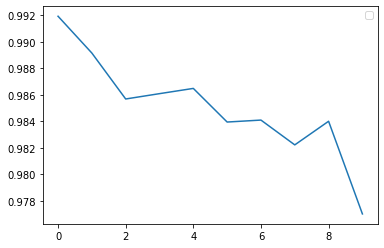

In [20]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.legend()
plt.show()

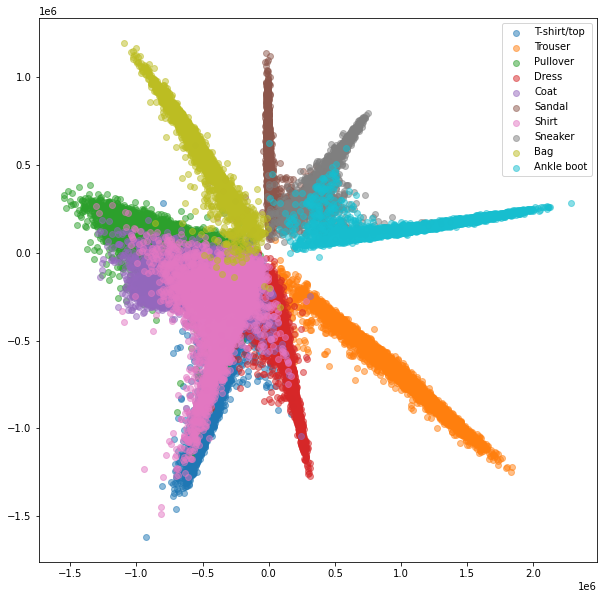

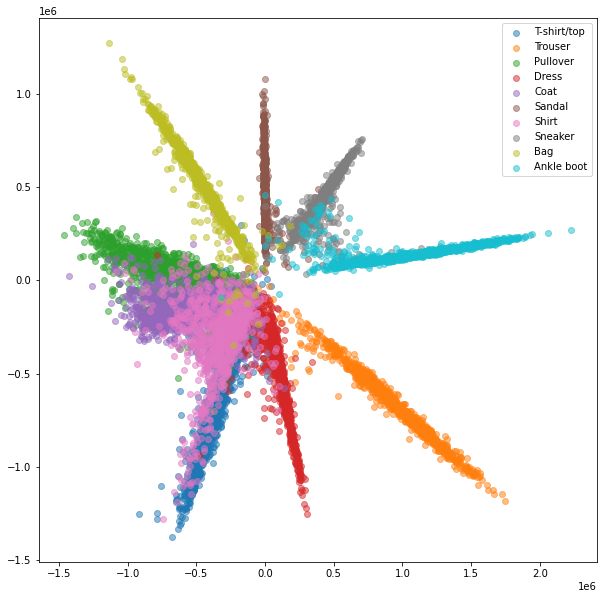

In [21]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [22]:
#Your Code Here


Epoch 1 Iteration 0: Loss = 0.5575507283210754, Number of mined triplets = 49620
Epoch 1 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 280: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 300: Loss

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 175.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 2 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 176.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 3 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 173.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 4 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 173.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 5 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 171.85it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 6 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 170.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 7 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 176.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 8 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 167.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 9 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 280: Loss = 0.0, Nu

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 166.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 10 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 220: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 240: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 260: Loss = 0.0, Number of mined triplets = 0
Epoch 10 Iteration 280:

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Iteration 460: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:02<00:00, 155.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23170000000000002
Epoch 1 Iteration 0: Loss = 1.0006376504898071, Number of mined triplets = 57133
Epoch 1 Iteration 20: Loss = 1.0000027418136597, Number of mined triplets = 69445
Epoch 1 Iteration 40: Loss = 1.0000004768371582, Number of mined triplets = 75426
Epoch 1 Iteration 60: Loss = 0.9999999403953552, Number of mined triplets = 73188
Epoch 1 Iteration 80: Loss = 1.0, Number of mined triplets = 60753
Epoch 1 Iteration 100: Loss = 0.9999999403953552, Number of mined triplets = 62993
Epoch 1 Iteration 120: Loss = 1.0, Number of mined triplets = 62357
Epoch 1 Iteration 140: Loss = 1.0, Number of mined triplets = 75573
Epoch 1 Iteration 160: Loss = 1.0, Number of mined triplets = 67962
Epoch 1 Iteration 180: Loss = 1.0, Number of mined triplets = 64474
Epoch 1 Iteration 200: Loss = 1.0, Number of mined triplets = 72247
Epoch 1 Iteration 220: Loss = 1.0, Number of mined triplets = 73376
Epoch 1 Iteration 240: Loss = 1.0, Number 

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Iteration 460: Loss = 1.0, Number of mined triplets = 69314


100%|██████████| 313/313 [00:01<00:00, 169.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2988
Epoch 2 Iteration 0: Loss = 1.0, Number of mined triplets = 55161
Epoch 2 Iteration 20: Loss = 1.0, Number of mined triplets = 66375
Epoch 2 Iteration 40: Loss = 0.9999999403953552, Number of mined triplets = 63076
Epoch 2 Iteration 60: Loss = 1.0, Number of mined triplets = 53853
Epoch 2 Iteration 80: Loss = 1.0, Number of mined triplets = 64410
Epoch 2 Iteration 100: Loss = 1.0, Number of mined triplets = 52325
Epoch 2 Iteration 120: Loss = 1.0, Number of mined triplets = 60089
Epoch 2 Iteration 140: Loss = 1.0, Number of mined triplets = 61023
Epoch 2 Iteration 160: Loss = 1.0, Number of mined triplets = 65277
Epoch 2 Iteration 180: Loss = 1.0, Number of mined triplets = 56190
Epoch 2 Iteration 200: Loss = 1.0, Number of mined triplets = 72392
Epoch 2 Iteration 220: Loss = 1.0, Number of mined triplets = 62805
Epoch 2 Iteration 240: Loss = 1.0, Number of mined triplets = 50354
Epoch 2 Iteration 260: Loss = 1.0, Number of mi

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Iteration 460: Loss = 1.0, Number of mined triplets = 55118


100%|██████████| 313/313 [00:01<00:00, 166.94it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3236
Epoch 3 Iteration 0: Loss = 1.0, Number of mined triplets = 57105
Epoch 3 Iteration 20: Loss = 0.9999999403953552, Number of mined triplets = 60134
Epoch 3 Iteration 40: Loss = 1.0, Number of mined triplets = 53532
Epoch 3 Iteration 60: Loss = 1.0, Number of mined triplets = 68169
Epoch 3 Iteration 80: Loss = 1.0, Number of mined triplets = 58012
Epoch 3 Iteration 100: Loss = 1.0, Number of mined triplets = 56683
Epoch 3 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 55638
Epoch 3 Iteration 140: Loss = 1.0, Number of mined triplets = 56935
Epoch 3 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 57160
Epoch 3 Iteration 180: Loss = 1.0, Number of mined triplets = 60334
Epoch 3 Iteration 200: Loss = 1.0, Number of mined triplets = 49019
Epoch 3 Iteration 220: Loss = 0.9999999403953552, Number of mined triplets = 63425
Epoch 3 Iteration 240: Loss = 1.0, Number of mined triplets = 53661
Ep

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Iteration 460: Loss = 1.0, Number of mined triplets = 51550


100%|██████████| 313/313 [00:01<00:00, 169.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3574
Epoch 4 Iteration 0: Loss = 1.0, Number of mined triplets = 41842
Epoch 4 Iteration 20: Loss = 1.0, Number of mined triplets = 48348
Epoch 4 Iteration 40: Loss = 0.9999999403953552, Number of mined triplets = 44948
Epoch 4 Iteration 60: Loss = 1.0, Number of mined triplets = 51954
Epoch 4 Iteration 80: Loss = 1.0, Number of mined triplets = 49646
Epoch 4 Iteration 100: Loss = 1.0, Number of mined triplets = 58968
Epoch 4 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 61744
Epoch 4 Iteration 140: Loss = 1.0, Number of mined triplets = 49606
Epoch 4 Iteration 160: Loss = 1.0, Number of mined triplets = 61101
Epoch 4 Iteration 180: Loss = 1.0, Number of mined triplets = 41384
Epoch 4 Iteration 200: Loss = 1.0, Number of mined triplets = 52411
Epoch 4 Iteration 220: Loss = 0.9999999403953552, Number of mined triplets = 48041
Epoch 4 Iteration 240: Loss = 1.0, Number of mined triplets = 54324
Epoch 4 Iteration

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Iteration 460: Loss = 1.0, Number of mined triplets = 41555


100%|██████████| 313/313 [00:01<00:00, 169.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3914
Epoch 5 Iteration 0: Loss = 1.0, Number of mined triplets = 52700
Epoch 5 Iteration 20: Loss = 1.0, Number of mined triplets = 51002
Epoch 5 Iteration 40: Loss = 1.0, Number of mined triplets = 48072
Epoch 5 Iteration 60: Loss = 0.9999999403953552, Number of mined triplets = 55024
Epoch 5 Iteration 80: Loss = 1.0, Number of mined triplets = 52591
Epoch 5 Iteration 100: Loss = 1.0, Number of mined triplets = 54423
Epoch 5 Iteration 120: Loss = 1.0, Number of mined triplets = 45387
Epoch 5 Iteration 140: Loss = 0.9999999403953552, Number of mined triplets = 43269
Epoch 5 Iteration 160: Loss = 0.9999999403953552, Number of mined triplets = 42433
Epoch 5 Iteration 180: Loss = 0.9999999403953552, Number of mined triplets = 50901
Epoch 5 Iteration 200: Loss = 1.0, Number of mined triplets = 56165
Epoch 5 Iteration 220: Loss = 1.0, Number of mined triplets = 42799
Epoch 5 Iteration 240: Loss = 1.0, Number of mined triplets = 54912
Ep

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Iteration 460: Loss = 1.0, Number of mined triplets = 47137


100%|██████████| 313/313 [00:01<00:00, 164.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.41200000000000003
Epoch 6 Iteration 0: Loss = 1.0, Number of mined triplets = 47843
Epoch 6 Iteration 20: Loss = 1.0, Number of mined triplets = 55421
Epoch 6 Iteration 40: Loss = 0.9999999403953552, Number of mined triplets = 43763
Epoch 6 Iteration 60: Loss = 1.0, Number of mined triplets = 49168
Epoch 6 Iteration 80: Loss = 0.9999999403953552, Number of mined triplets = 49610
Epoch 6 Iteration 100: Loss = 1.0, Number of mined triplets = 43306
Epoch 6 Iteration 120: Loss = 1.0, Number of mined triplets = 50361
Epoch 6 Iteration 140: Loss = 1.0, Number of mined triplets = 43852
Epoch 6 Iteration 160: Loss = 1.0, Number of mined triplets = 52467
Epoch 6 Iteration 180: Loss = 1.0, Number of mined triplets = 42005
Epoch 6 Iteration 200: Loss = 1.0, Number of mined triplets = 37820
Epoch 6 Iteration 220: Loss = 1.0, Number of mined triplets = 43051
Epoch 6 Iteration 240: Loss = 1.0, Number of mined triplets = 44036
Epoch 6 Iteration 2

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Iteration 460: Loss = 1.0, Number of mined triplets = 45429


100%|██████████| 313/313 [00:01<00:00, 167.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.3915
Epoch 7 Iteration 0: Loss = 1.0, Number of mined triplets = 56099
Epoch 7 Iteration 20: Loss = 1.0, Number of mined triplets = 41558
Epoch 7 Iteration 40: Loss = 1.0, Number of mined triplets = 50259
Epoch 7 Iteration 60: Loss = 1.0, Number of mined triplets = 52037
Epoch 7 Iteration 80: Loss = 1.0, Number of mined triplets = 39877
Epoch 7 Iteration 100: Loss = 1.0, Number of mined triplets = 44420
Epoch 7 Iteration 120: Loss = 1.0, Number of mined triplets = 56054
Epoch 7 Iteration 140: Loss = 0.9999999403953552, Number of mined triplets = 45566
Epoch 7 Iteration 160: Loss = 1.0, Number of mined triplets = 39446
Epoch 7 Iteration 180: Loss = 1.0, Number of mined triplets = 40030
Epoch 7 Iteration 200: Loss = 1.0, Number of mined triplets = 41624
Epoch 7 Iteration 220: Loss = 0.9999999403953552, Number of mined triplets = 58357
Epoch 7 Iteration 240: Loss = 1.0, Number of mined triplets = 42177
Epoch 7 Iteration 260: Loss = 1.

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Iteration 460: Loss = 1.0, Number of mined triplets = 42631


100%|██████████| 313/313 [00:01<00:00, 170.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4413
Epoch 8 Iteration 0: Loss = 1.0, Number of mined triplets = 44194
Epoch 8 Iteration 20: Loss = 1.0, Number of mined triplets = 55870
Epoch 8 Iteration 40: Loss = 1.0, Number of mined triplets = 40607
Epoch 8 Iteration 60: Loss = 1.0, Number of mined triplets = 38183
Epoch 8 Iteration 80: Loss = 1.0, Number of mined triplets = 42076
Epoch 8 Iteration 100: Loss = 1.0, Number of mined triplets = 42362
Epoch 8 Iteration 120: Loss = 1.0, Number of mined triplets = 43400
Epoch 8 Iteration 140: Loss = 1.0, Number of mined triplets = 43897
Epoch 8 Iteration 160: Loss = 1.0, Number of mined triplets = 36060
Epoch 8 Iteration 180: Loss = 1.0, Number of mined triplets = 43258
Epoch 8 Iteration 200: Loss = 1.0, Number of mined triplets = 47709
Epoch 8 Iteration 220: Loss = 0.9999999403953552, Number of mined triplets = 40879
Epoch 8 Iteration 240: Loss = 1.0, Number of mined triplets = 44359
Epoch 8 Iteration 260: Loss = 1.0, Number of mi

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Iteration 460: Loss = 1.0, Number of mined triplets = 42083


100%|██████████| 313/313 [00:01<00:00, 174.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.4269
Epoch 9 Iteration 0: Loss = 1.0, Number of mined triplets = 53863
Epoch 9 Iteration 20: Loss = 1.0, Number of mined triplets = 50909
Epoch 9 Iteration 40: Loss = 1.0, Number of mined triplets = 42381
Epoch 9 Iteration 60: Loss = 1.0, Number of mined triplets = 43693
Epoch 9 Iteration 80: Loss = 1.0, Number of mined triplets = 41046
Epoch 9 Iteration 100: Loss = 1.0, Number of mined triplets = 42223
Epoch 9 Iteration 120: Loss = 1.0, Number of mined triplets = 33223
Epoch 9 Iteration 140: Loss = 1.0, Number of mined triplets = 40284
Epoch 9 Iteration 160: Loss = 1.0, Number of mined triplets = 39855
Epoch 9 Iteration 180: Loss = 1.0, Number of mined triplets = 41027
Epoch 9 Iteration 200: Loss = 1.0, Number of mined triplets = 46752
Epoch 9 Iteration 220: Loss = 1.0, Number of mined triplets = 44323
Epoch 9 Iteration 240: Loss = 1.0, Number of mined triplets = 51881
Epoch 9 Iteration 260: Loss = 1.0, Number of mined triplets = 

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Iteration 460: Loss = 1.0, Number of mined triplets = 49358


100%|██████████| 313/313 [00:01<00:00, 167.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.453
Epoch 10 Iteration 0: Loss = 1.0, Number of mined triplets = 60967
Epoch 10 Iteration 20: Loss = 1.0, Number of mined triplets = 48898
Epoch 10 Iteration 40: Loss = 1.0, Number of mined triplets = 38065
Epoch 10 Iteration 60: Loss = 1.0, Number of mined triplets = 55583
Epoch 10 Iteration 80: Loss = 0.9999999403953552, Number of mined triplets = 50596
Epoch 10 Iteration 100: Loss = 1.0, Number of mined triplets = 43006
Epoch 10 Iteration 120: Loss = 0.9999999403953552, Number of mined triplets = 44081
Epoch 10 Iteration 140: Loss = 1.0, Number of mined triplets = 37785
Epoch 10 Iteration 160: Loss = 1.0, Number of mined triplets = 33130
Epoch 10 Iteration 180: Loss = 1.0, Number of mined triplets = 39287
Epoch 10 Iteration 200: Loss = 1.0, Number of mined triplets = 38448
Epoch 10 Iteration 220: Loss = 1.0, Number of mined triplets = 39334
Epoch 10 Iteration 240: Loss = 1.0, Number of mined triplets = 41284
Epoch 10 Iteration 2

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Iteration 460: Loss = 1.0, Number of mined triplets = 35520


100%|██████████| 313/313 [00:01<00:00, 174.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.44830000000000003
Epoch 1 Iteration 0: Loss = 0.9999995827674866, Number of mined triplets = 138314
Epoch 1 Iteration 20: Loss = 0.9338093400001526, Number of mined triplets = 33520
Epoch 1 Iteration 40: Loss = 0.9180036783218384, Number of mined triplets = 20484
Epoch 1 Iteration 60: Loss = 0.9194315671920776, Number of mined triplets = 18060
Epoch 1 Iteration 80: Loss = 0.9156678915023804, Number of mined triplets = 19383
Epoch 1 Iteration 100: Loss = 0.9126672744750977, Number of mined triplets = 19693
Epoch 1 Iteration 120: Loss = 0.9043177366256714, Number of mined triplets = 20169
Epoch 1 Iteration 140: Loss = 0.8985657095909119, Number of mined triplets = 18026
Epoch 1 Iteration 160: Loss = 0.899649441242218, Number of mined triplets = 15883
Epoch 1 Iteration 180: Loss = 0.9004259705543518, Number of mined triplets = 16755
Epoch 1 Iteration 200: Loss = 0.8980271816253662, Number of mined triplets = 17306
Epoch 1 Iteration 22

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Iteration 460: Loss = 0.9053958058357239, Number of mined triplets = 15667


100%|██████████| 313/313 [00:01<00:00, 171.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6971
Epoch 2 Iteration 0: Loss = 0.9086740612983704, Number of mined triplets = 21384
Epoch 2 Iteration 20: Loss = 0.9055192470550537, Number of mined triplets = 19913
Epoch 2 Iteration 40: Loss = 0.8934664130210876, Number of mined triplets = 17620
Epoch 2 Iteration 60: Loss = 0.9166679382324219, Number of mined triplets = 18216
Epoch 2 Iteration 80: Loss = 0.8925923705101013, Number of mined triplets = 17809
Epoch 2 Iteration 100: Loss = 0.8955621719360352, Number of mined triplets = 15594
Epoch 2 Iteration 120: Loss = 0.9046897292137146, Number of mined triplets = 17839
Epoch 2 Iteration 140: Loss = 0.8875545859336853, Number of mined triplets = 14907
Epoch 2 Iteration 160: Loss = 0.9028539657592773, Number of mined triplets = 18874
Epoch 2 Iteration 180: Loss = 0.9030112028121948, Number of mined triplets = 17157
Epoch 2 Iteration 200: Loss = 0.8932420611381531, Number of mined triplets = 21278
Epoch 2 Iteration 220: Loss = 0.8

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Iteration 460: Loss = 0.8913324475288391, Number of mined triplets = 12778


100%|██████████| 313/313 [00:01<00:00, 159.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7321000000000001
Epoch 3 Iteration 0: Loss = 0.8815793991088867, Number of mined triplets = 16394
Epoch 3 Iteration 20: Loss = 0.8879086971282959, Number of mined triplets = 18206
Epoch 3 Iteration 40: Loss = 0.8702377080917358, Number of mined triplets = 15322
Epoch 3 Iteration 60: Loss = 0.8718324303627014, Number of mined triplets = 17599
Epoch 3 Iteration 80: Loss = 0.89304518699646, Number of mined triplets = 13432
Epoch 3 Iteration 100: Loss = 0.8965728878974915, Number of mined triplets = 21278
Epoch 3 Iteration 120: Loss = 0.8909969329833984, Number of mined triplets = 18694
Epoch 3 Iteration 140: Loss = 0.8849343657493591, Number of mined triplets = 13958
Epoch 3 Iteration 160: Loss = 0.8812564015388489, Number of mined triplets = 20300
Epoch 3 Iteration 180: Loss = 0.8815743923187256, Number of mined triplets = 19239
Epoch 3 Iteration 200: Loss = 0.878166675567627, Number of mined triplets = 14717
Epoch 3 Iteration 220: L

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Iteration 460: Loss = 0.8680294156074524, Number of mined triplets = 19672


100%|██████████| 313/313 [00:01<00:00, 174.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7483000000000001
Epoch 4 Iteration 0: Loss = 0.8754157423973083, Number of mined triplets = 14877
Epoch 4 Iteration 20: Loss = 0.8770228028297424, Number of mined triplets = 15392
Epoch 4 Iteration 40: Loss = 0.8907573819160461, Number of mined triplets = 17317
Epoch 4 Iteration 60: Loss = 0.8770118951797485, Number of mined triplets = 12520
Epoch 4 Iteration 80: Loss = 0.8716935515403748, Number of mined triplets = 14491
Epoch 4 Iteration 100: Loss = 0.8929284811019897, Number of mined triplets = 14069
Epoch 4 Iteration 120: Loss = 0.8772265315055847, Number of mined triplets = 15418
Epoch 4 Iteration 140: Loss = 0.8802658915519714, Number of mined triplets = 12202
Epoch 4 Iteration 160: Loss = 0.8957470655441284, Number of mined triplets = 17289
Epoch 4 Iteration 180: Loss = 0.8907768726348877, Number of mined triplets = 13692
Epoch 4 Iteration 200: Loss = 0.8808194994926453, Number of mined triplets = 17434
Epoch 4 Iteration 220

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Iteration 460: Loss = 0.8699554204940796, Number of mined triplets = 19058


100%|██████████| 313/313 [00:01<00:00, 166.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7692
Epoch 5 Iteration 0: Loss = 0.8939294219017029, Number of mined triplets = 16144
Epoch 5 Iteration 20: Loss = 0.8918048143386841, Number of mined triplets = 16151
Epoch 5 Iteration 40: Loss = 0.8904474973678589, Number of mined triplets = 13434
Epoch 5 Iteration 60: Loss = 0.8775680065155029, Number of mined triplets = 15660
Epoch 5 Iteration 80: Loss = 0.8862118124961853, Number of mined triplets = 18762
Epoch 5 Iteration 100: Loss = 0.892102062702179, Number of mined triplets = 18511
Epoch 5 Iteration 120: Loss = 0.8695186376571655, Number of mined triplets = 14814
Epoch 5 Iteration 140: Loss = 0.8591296076774597, Number of mined triplets = 17567
Epoch 5 Iteration 160: Loss = 0.8773807883262634, Number of mined triplets = 15596
Epoch 5 Iteration 180: Loss = 0.8659078478813171, Number of mined triplets = 15566
Epoch 5 Iteration 200: Loss = 0.8653222918510437, Number of mined triplets = 12015
Epoch 5 Iteration 220: Loss = 0.89

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Iteration 460: Loss = 0.8784863948822021, Number of mined triplets = 13002


100%|██████████| 313/313 [00:01<00:00, 168.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.798
Epoch 6 Iteration 0: Loss = 0.8901480436325073, Number of mined triplets = 13952
Epoch 6 Iteration 20: Loss = 0.8818289041519165, Number of mined triplets = 19184
Epoch 6 Iteration 40: Loss = 0.8794587254524231, Number of mined triplets = 11286
Epoch 6 Iteration 60: Loss = 0.8636154532432556, Number of mined triplets = 21285
Epoch 6 Iteration 80: Loss = 0.8950144052505493, Number of mined triplets = 6826
Epoch 6 Iteration 100: Loss = 0.847859263420105, Number of mined triplets = 17318
Epoch 6 Iteration 120: Loss = 0.8589516878128052, Number of mined triplets = 11246
Epoch 6 Iteration 140: Loss = 0.8877144455909729, Number of mined triplets = 14349
Epoch 6 Iteration 160: Loss = 0.8814578652381897, Number of mined triplets = 15166
Epoch 6 Iteration 180: Loss = 0.8826826214790344, Number of mined triplets = 16574
Epoch 6 Iteration 200: Loss = 0.8762953281402588, Number of mined triplets = 12997
Epoch 6 Iteration 220: Loss = 0.8937

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Iteration 460: Loss = 0.8646000623703003, Number of mined triplets = 15569


100%|██████████| 313/313 [00:01<00:00, 166.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8117000000000001
Epoch 7 Iteration 0: Loss = 0.8889591097831726, Number of mined triplets = 17115
Epoch 7 Iteration 20: Loss = 0.8913389444351196, Number of mined triplets = 12457
Epoch 7 Iteration 40: Loss = 0.8749465942382812, Number of mined triplets = 11246
Epoch 7 Iteration 60: Loss = 0.8705378174781799, Number of mined triplets = 16622
Epoch 7 Iteration 80: Loss = 0.8629211783409119, Number of mined triplets = 15047
Epoch 7 Iteration 100: Loss = 0.868089497089386, Number of mined triplets = 12277
Epoch 7 Iteration 120: Loss = 0.884408175945282, Number of mined triplets = 12389
Epoch 7 Iteration 140: Loss = 0.8938412666320801, Number of mined triplets = 14019
Epoch 7 Iteration 160: Loss = 0.8818163871765137, Number of mined triplets = 12795
Epoch 7 Iteration 180: Loss = 0.8604628443717957, Number of mined triplets = 15605
Epoch 7 Iteration 200: Loss = 0.8837365508079529, Number of mined triplets = 16691
Epoch 7 Iteration 220: 

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Iteration 460: Loss = 0.8789554834365845, Number of mined triplets = 19918


100%|██████████| 313/313 [00:01<00:00, 166.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8127000000000001
Epoch 8 Iteration 0: Loss = 0.8507982492446899, Number of mined triplets = 16328
Epoch 8 Iteration 20: Loss = 0.8702659606933594, Number of mined triplets = 12850
Epoch 8 Iteration 40: Loss = 0.8843716382980347, Number of mined triplets = 14684
Epoch 8 Iteration 60: Loss = 0.881155788898468, Number of mined triplets = 10325
Epoch 8 Iteration 80: Loss = 0.8702282905578613, Number of mined triplets = 19060
Epoch 8 Iteration 100: Loss = 0.8862531781196594, Number of mined triplets = 17668
Epoch 8 Iteration 120: Loss = 0.874263346195221, Number of mined triplets = 12692
Epoch 8 Iteration 140: Loss = 0.8599359393119812, Number of mined triplets = 11745
Epoch 8 Iteration 160: Loss = 0.8854534029960632, Number of mined triplets = 16208
Epoch 8 Iteration 180: Loss = 0.8735390305519104, Number of mined triplets = 15791
Epoch 8 Iteration 200: Loss = 0.8745163083076477, Number of mined triplets = 18506
Epoch 8 Iteration 220: 

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Iteration 460: Loss = 0.8630064725875854, Number of mined triplets = 15659


100%|██████████| 313/313 [00:01<00:00, 169.50it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8234
Epoch 9 Iteration 0: Loss = 0.8864207863807678, Number of mined triplets = 16219
Epoch 9 Iteration 20: Loss = 0.8527354598045349, Number of mined triplets = 12876
Epoch 9 Iteration 40: Loss = 0.8767498731613159, Number of mined triplets = 11373
Epoch 9 Iteration 60: Loss = 0.885536253452301, Number of mined triplets = 17174
Epoch 9 Iteration 80: Loss = 0.8794888257980347, Number of mined triplets = 12575
Epoch 9 Iteration 100: Loss = 0.8748795986175537, Number of mined triplets = 12686
Epoch 9 Iteration 120: Loss = 0.8770760893821716, Number of mined triplets = 16023
Epoch 9 Iteration 140: Loss = 0.8620883822441101, Number of mined triplets = 13796
Epoch 9 Iteration 160: Loss = 0.8797845840454102, Number of mined triplets = 14272
Epoch 9 Iteration 180: Loss = 0.868976354598999, Number of mined triplets = 12246
Epoch 9 Iteration 200: Loss = 0.8649030327796936, Number of mined triplets = 16019
Epoch 9 Iteration 220: Loss = 0.900

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Iteration 460: Loss = 0.8725683093070984, Number of mined triplets = 14615


100%|██████████| 313/313 [00:01<00:00, 168.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8323
Epoch 10 Iteration 0: Loss = 0.8805651664733887, Number of mined triplets = 10881
Epoch 10 Iteration 20: Loss = 0.8802434802055359, Number of mined triplets = 14029
Epoch 10 Iteration 40: Loss = 0.8878809809684753, Number of mined triplets = 16944
Epoch 10 Iteration 60: Loss = 0.8975204229354858, Number of mined triplets = 16458
Epoch 10 Iteration 80: Loss = 0.8612369894981384, Number of mined triplets = 13607
Epoch 10 Iteration 100: Loss = 0.8799651265144348, Number of mined triplets = 16258
Epoch 10 Iteration 120: Loss = 0.8900204300880432, Number of mined triplets = 10021
Epoch 10 Iteration 140: Loss = 0.8804499506950378, Number of mined triplets = 13496
Epoch 10 Iteration 160: Loss = 0.8653655052185059, Number of mined triplets = 13841
Epoch 10 Iteration 180: Loss = 0.8963795304298401, Number of mined triplets = 12230
Epoch 10 Iteration 200: Loss = 0.8868216276168823, Number of mined triplets = 13044
Epoch 10 Iteration 220

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Iteration 460: Loss = 0.877366304397583, Number of mined triplets = 9752


100%|██████████| 313/313 [00:01<00:00, 167.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8376


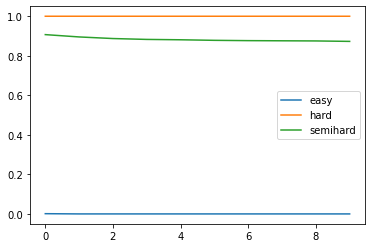

In [24]:
# SOLUTION

model = EmbeddingNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for triplet in ["easy", "hard", "semihard"]:
    mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets=triplet)
    loss_evolution = []
    for epoch in range(1, num_epochs + 1):
        loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
        loss_evolution.append(loss)
        test(train_dataset, test_dataset, model, accuracy_calculator)
    
    plt.plot(loss_evolution, label=triplet)

plt.legend()
plt.show()

<br>
<span style="color:blue">

**Open Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [ ]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE. The T-SNE library is installed in the cell below check the [github repo](https://github.com/DmitryUlyanov/Multicore-TSNE) for info on how to use it. Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few**

</span>

In [25]:
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_components=2, verbose=1, n_jobs=2)

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=68502 sha256=d4d8c2855f029d0d72f3dd64dbfae0153bcd2eb553d31aaa0895f1e894f131c1
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [26]:
# Your Code Here


In [28]:
# SOLUTION

class EmbeddingNet_128(nn.Module):
    def __init__(self):
        super(EmbeddingNet_128, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet_128().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 0.9049686193466187, Number of mined triplets = 101558
Epoch 1 Iteration 20: Loss = 0.9044931530952454, Number of mined triplets = 18549
Epoch 1 Iteration 40: Loss = 0.9035377502441406, Number of mined triplets = 21714
Epoch 1 Iteration 60: Loss = 0.8949370980262756, Number of mined triplets = 9603
Epoch 1 Iteration 80: Loss = 0.8950626254081726, Number of mined triplets = 9743
Epoch 1 Iteration 100: Loss = 0.8991357684135437, Number of mined triplets = 8865
Epoch 1 Iteration 120: Loss = 0.8980212807655334, Number of mined triplets = 9788
Epoch 1 Iteration 140: Loss = 0.8997042179107666, Number of mined triplets = 9281
Epoch 1 Iteration 160: Loss = 0.8932558298110962, Number of mined triplets = 6914
Epoch 1 Iteration 180: Loss = 0.903301477432251, Number of mined triplets = 12008
Epoch 1 Iteration 200: Loss = 0.8936310410499573, Number of mined triplets = 7587
Epoch 1 Iteration 220: Loss = 0.8932227492332458, Number of mined triplets = 4408
Epoch 1 Iteration 

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1 Iteration 460: Loss = 0.8928276300430298, Number of mined triplets = 5231


100%|██████████| 313/313 [00:01<00:00, 165.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550000000000001
Epoch 2 Iteration 0: Loss = 0.8943697810173035, Number of mined triplets = 9155
Epoch 2 Iteration 20: Loss = 0.8907006978988647, Number of mined triplets = 6841
Epoch 2 Iteration 40: Loss = 0.8903383016586304, Number of mined triplets = 5177
Epoch 2 Iteration 60: Loss = 0.8935157060623169, Number of mined triplets = 5903
Epoch 2 Iteration 80: Loss = 0.8960040807723999, Number of mined triplets = 7787
Epoch 2 Iteration 100: Loss = 0.8900551199913025, Number of mined triplets = 4668
Epoch 2 Iteration 120: Loss = 0.8930345177650452, Number of mined triplets = 6356
Epoch 2 Iteration 140: Loss = 0.8951860666275024, Number of mined triplets = 7528
Epoch 2 Iteration 160: Loss = 0.8922394514083862, Number of mined triplets = 8024
Epoch 2 Iteration 180: Loss = 0.8914254903793335, Number of mined triplets = 6948
Epoch 2 Iteration 200: Loss = 0.8902431726455688, Number of mined triplets = 5343
Epoch 2 Iteration 220: Loss = 0.

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2 Iteration 460: Loss = 0.8925521969795227, Number of mined triplets = 5040


100%|██████████| 313/313 [00:01<00:00, 171.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8749
Epoch 3 Iteration 0: Loss = 0.8953140377998352, Number of mined triplets = 7266
Epoch 3 Iteration 20: Loss = 0.8897109031677246, Number of mined triplets = 7957
Epoch 3 Iteration 40: Loss = 0.8902915716171265, Number of mined triplets = 3962
Epoch 3 Iteration 60: Loss = 0.8905425071716309, Number of mined triplets = 4596
Epoch 3 Iteration 80: Loss = 0.8902340531349182, Number of mined triplets = 4177
Epoch 3 Iteration 100: Loss = 0.8942065834999084, Number of mined triplets = 7328
Epoch 3 Iteration 120: Loss = 0.8919777274131775, Number of mined triplets = 8785
Epoch 3 Iteration 140: Loss = 0.8900229334831238, Number of mined triplets = 6031
Epoch 3 Iteration 160: Loss = 0.8926827907562256, Number of mined triplets = 3458
Epoch 3 Iteration 180: Loss = 0.8895617127418518, Number of mined triplets = 6116
Epoch 3 Iteration 200: Loss = 0.8899624943733215, Number of mined triplets = 4684
Epoch 3 Iteration 220: Loss = 0.890619456768

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3 Iteration 460: Loss = 0.8920345306396484, Number of mined triplets = 4250


100%|██████████| 313/313 [00:01<00:00, 169.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8859
Epoch 4 Iteration 0: Loss = 0.8897830247879028, Number of mined triplets = 4593
Epoch 4 Iteration 20: Loss = 0.892455518245697, Number of mined triplets = 6325
Epoch 4 Iteration 40: Loss = 0.8927074670791626, Number of mined triplets = 6183
Epoch 4 Iteration 60: Loss = 0.887890636920929, Number of mined triplets = 5328
Epoch 4 Iteration 80: Loss = 0.8931792378425598, Number of mined triplets = 5532
Epoch 4 Iteration 100: Loss = 0.8917031288146973, Number of mined triplets = 6340
Epoch 4 Iteration 120: Loss = 0.8883948922157288, Number of mined triplets = 2788
Epoch 4 Iteration 140: Loss = 0.8898805379867554, Number of mined triplets = 4709
Epoch 4 Iteration 160: Loss = 0.8908823728561401, Number of mined triplets = 6118
Epoch 4 Iteration 180: Loss = 0.8944646716117859, Number of mined triplets = 6941
Epoch 4 Iteration 200: Loss = 0.8893306255340576, Number of mined triplets = 4700
Epoch 4 Iteration 220: Loss = 0.89251226186752

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4 Iteration 460: Loss = 0.8940008878707886, Number of mined triplets = 6224


100%|██████████| 313/313 [00:01<00:00, 166.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8881
Epoch 5 Iteration 0: Loss = 0.8914764523506165, Number of mined triplets = 7848
Epoch 5 Iteration 20: Loss = 0.8935308456420898, Number of mined triplets = 6231
Epoch 5 Iteration 40: Loss = 0.8918827176094055, Number of mined triplets = 3383
Epoch 5 Iteration 60: Loss = 0.8939260840415955, Number of mined triplets = 5748
Epoch 5 Iteration 80: Loss = 0.888955295085907, Number of mined triplets = 5036
Epoch 5 Iteration 100: Loss = 0.8974797129631042, Number of mined triplets = 4308
Epoch 5 Iteration 120: Loss = 0.8914070129394531, Number of mined triplets = 4377
Epoch 5 Iteration 140: Loss = 0.8914228081703186, Number of mined triplets = 6570
Epoch 5 Iteration 160: Loss = 0.8914227485656738, Number of mined triplets = 8810
Epoch 5 Iteration 180: Loss = 0.8920794725418091, Number of mined triplets = 5944
Epoch 5 Iteration 200: Loss = 0.8899656534194946, Number of mined triplets = 6576
Epoch 5 Iteration 220: Loss = 0.8855958580970

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5 Iteration 460: Loss = 0.892069399356842, Number of mined triplets = 4299


100%|██████████| 313/313 [00:01<00:00, 163.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8922
Epoch 6 Iteration 0: Loss = 0.892733097076416, Number of mined triplets = 3309
Epoch 6 Iteration 20: Loss = 0.8957035541534424, Number of mined triplets = 3672
Epoch 6 Iteration 40: Loss = 0.8918392658233643, Number of mined triplets = 3636
Epoch 6 Iteration 60: Loss = 0.8923029899597168, Number of mined triplets = 3990
Epoch 6 Iteration 80: Loss = 0.8890140056610107, Number of mined triplets = 5155
Epoch 6 Iteration 100: Loss = 0.8919268250465393, Number of mined triplets = 5116
Epoch 6 Iteration 120: Loss = 0.8852651715278625, Number of mined triplets = 3426
Epoch 6 Iteration 140: Loss = 0.8895782828330994, Number of mined triplets = 3701
Epoch 6 Iteration 160: Loss = 0.8915680646896362, Number of mined triplets = 6072
Epoch 6 Iteration 180: Loss = 0.8935840725898743, Number of mined triplets = 5584
Epoch 6 Iteration 200: Loss = 0.8892123103141785, Number of mined triplets = 7046
Epoch 6 Iteration 220: Loss = 0.8908708095550

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6 Iteration 460: Loss = 0.8917309641838074, Number of mined triplets = 4172


100%|██████████| 313/313 [00:01<00:00, 169.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8877
Epoch 7 Iteration 0: Loss = 0.8914217948913574, Number of mined triplets = 2925
Epoch 7 Iteration 20: Loss = 0.8894246220588684, Number of mined triplets = 3614
Epoch 7 Iteration 40: Loss = 0.8936530947685242, Number of mined triplets = 6029
Epoch 7 Iteration 60: Loss = 0.8930008411407471, Number of mined triplets = 4819
Epoch 7 Iteration 80: Loss = 0.8884797096252441, Number of mined triplets = 4519
Epoch 7 Iteration 100: Loss = 0.8927682638168335, Number of mined triplets = 3657
Epoch 7 Iteration 120: Loss = 0.8892411589622498, Number of mined triplets = 4194
Epoch 7 Iteration 140: Loss = 0.8897966146469116, Number of mined triplets = 4388
Epoch 7 Iteration 160: Loss = 0.891483724117279, Number of mined triplets = 3308
Epoch 7 Iteration 180: Loss = 0.8887085318565369, Number of mined triplets = 4143
Epoch 7 Iteration 200: Loss = 0.8886324763298035, Number of mined triplets = 2958
Epoch 7 Iteration 220: Loss = 0.8906036019325

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7 Iteration 460: Loss = 0.893695056438446, Number of mined triplets = 7729


100%|██████████| 313/313 [00:01<00:00, 169.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8884000000000001
Epoch 8 Iteration 0: Loss = 0.892630398273468, Number of mined triplets = 6552
Epoch 8 Iteration 20: Loss = 0.8941066861152649, Number of mined triplets = 8120
Epoch 8 Iteration 40: Loss = 0.8885771632194519, Number of mined triplets = 4335
Epoch 8 Iteration 60: Loss = 0.8943487405776978, Number of mined triplets = 5250
Epoch 8 Iteration 80: Loss = 0.8865383267402649, Number of mined triplets = 3617
Epoch 8 Iteration 100: Loss = 0.8903681039810181, Number of mined triplets = 4366
Epoch 8 Iteration 120: Loss = 0.8889363408088684, Number of mined triplets = 3431
Epoch 8 Iteration 140: Loss = 0.889278769493103, Number of mined triplets = 3153
Epoch 8 Iteration 160: Loss = 0.8853562474250793, Number of mined triplets = 3002
Epoch 8 Iteration 180: Loss = 0.8901196718215942, Number of mined triplets = 5685
Epoch 8 Iteration 200: Loss = 0.886542558670044, Number of mined triplets = 6458
Epoch 8 Iteration 220: Loss = 0.888

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8 Iteration 460: Loss = 0.8908008933067322, Number of mined triplets = 4874


100%|██████████| 313/313 [00:01<00:00, 170.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.894
Epoch 9 Iteration 0: Loss = 0.8887274265289307, Number of mined triplets = 3851
Epoch 9 Iteration 20: Loss = 0.8900251984596252, Number of mined triplets = 3791
Epoch 9 Iteration 40: Loss = 0.8932247161865234, Number of mined triplets = 6423
Epoch 9 Iteration 60: Loss = 0.8896945714950562, Number of mined triplets = 4247
Epoch 9 Iteration 80: Loss = 0.8912313580513, Number of mined triplets = 4090
Epoch 9 Iteration 100: Loss = 0.8927892446517944, Number of mined triplets = 4019
Epoch 9 Iteration 120: Loss = 0.8872807025909424, Number of mined triplets = 3531
Epoch 9 Iteration 140: Loss = 0.8874609470367432, Number of mined triplets = 4126
Epoch 9 Iteration 160: Loss = 0.8873946070671082, Number of mined triplets = 3754
Epoch 9 Iteration 180: Loss = 0.8918500542640686, Number of mined triplets = 9173
Epoch 9 Iteration 200: Loss = 0.8877151012420654, Number of mined triplets = 3710
Epoch 9 Iteration 220: Loss = 0.888779878616333,

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9 Iteration 460: Loss = 0.8877643346786499, Number of mined triplets = 3340


100%|██████████| 313/313 [00:01<00:00, 169.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.896
Epoch 10 Iteration 0: Loss = 0.8915560245513916, Number of mined triplets = 3102
Epoch 10 Iteration 20: Loss = 0.8907235264778137, Number of mined triplets = 3751
Epoch 10 Iteration 40: Loss = 0.8885525465011597, Number of mined triplets = 3762
Epoch 10 Iteration 60: Loss = 0.893017053604126, Number of mined triplets = 4225
Epoch 10 Iteration 80: Loss = 0.8920078873634338, Number of mined triplets = 3352
Epoch 10 Iteration 100: Loss = 0.8868573904037476, Number of mined triplets = 3170
Epoch 10 Iteration 120: Loss = 0.8828849792480469, Number of mined triplets = 3457
Epoch 10 Iteration 140: Loss = 0.8886253833770752, Number of mined triplets = 5187
Epoch 10 Iteration 160: Loss = 0.8887780904769897, Number of mined triplets = 4447
Epoch 10 Iteration 180: Loss = 0.8904480338096619, Number of mined triplets = 6235
Epoch 10 Iteration 200: Loss = 0.8937479853630066, Number of mined triplets = 6560
Epoch 10 Iteration 220: Loss = 0.88

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10 Iteration 460: Loss = 0.8933907151222229, Number of mined triplets = 6593


100%|██████████| 313/313 [00:01<00:00, 166.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8967


100%|██████████| 313/313 [00:01<00:00, 174.49it/s]


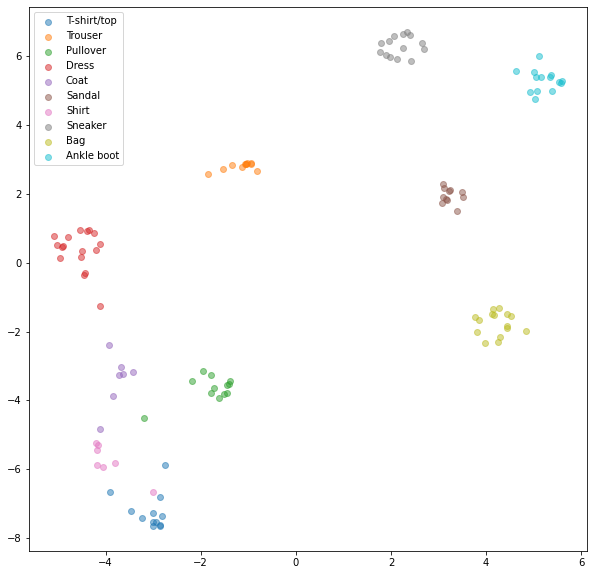

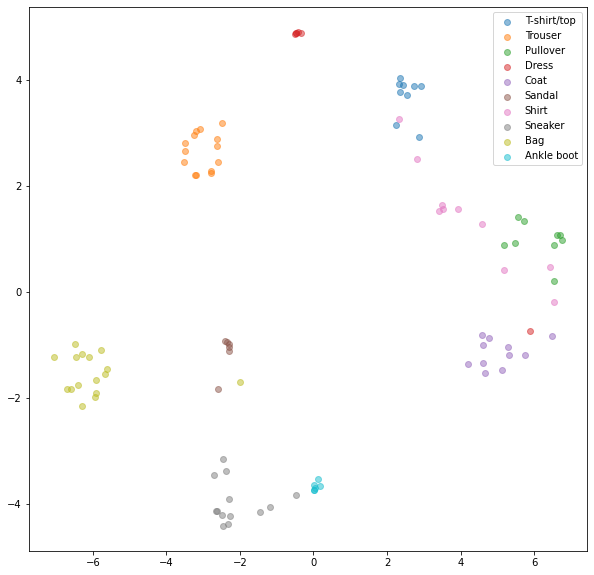

In [31]:
train_embeddings, train_labels = get_all_embeddings(train_dataset, model)

train_embeddings = tsne.fit_transform(train_embeddings[::500].cpu())

plot_embeddings(train_embeddings, train_labels[::500].cpu())
val_embeddings_baseline, val_labels_baseline = get_all_embeddings(test_dataset, model)
val_embeddings_baseline = tsne.fit_transform(val_embeddings_baseline[::100].cpu())

plot_embeddings(val_embeddings_baseline, val_labels_baseline[::100].cpu())